# Introduction

We will use the python bindings for the [FANN](http://leenissen.dk/fann/wp/) (Fast Artificial Neural Networks) C-library to construct a neural network to map from the potential (represented by Fourier components, see [potentials.ipynb](potentials.ipynb)) to the eigenvalues (really, the difference between the eigenvalues and the square-well eigenvalues normalized by $\sqrt{\langle V_0^2 \rangle}$, see [eigenvalues.ipynb](eigenvalues.ipynb)). For FANN documentation, see [http://libfann.github.io/fann/docs/files/fann-h.html](http://libfann.github.io/fann/docs/files/fann-h.html).

# Preliminaries

In [79]:
%matplotlib inline
import numpy as np
from numpy.random import normal, randint
import matplotlib.pyplot as plt
from fann2 import libfann
from sklearn.cross_validation import train_test_split

# Number of basis states for the wavefunctions
NBW = 50
nbws = np.arange(1, NBW+1)
# Number of potentials:
NV = int(1E5)
# Number of basis states in the potential:
NB = 10
ns = np.arange(1, NB+1)
# lambda (variance of Legendre coefficients):
lam = 0.75
# The variance of the n=0 legendre coefficient V_0:
V20 = 10

# Input file:
filepath = "../Data/eigenvalues_NV" + str(NV) \
    + "_NB" + str(NB) + "_lam" \
    + str(lam) + "_V20" + str(V20) + ".npy"
filepathSD = "../Data/eigenvaluesSD_NV" + str(NV) \
    + "_NB" + str(NB) + "_lam" \
    + str(lam) + "_V20" + str(V20) + ".npy"
data = np.load(filepath)
dataSD = np.load(filepathSD)
VSns = data[::,0:10]
VCns = data[::,10:20]
eigs = data[::,20::]

In [80]:
print(data.shape, VSns.shape, VCns.shape, eigs.shape)
print(dataSD.shape)

(100000, 60) (100000, 10) (100000, 10) (100000, 40)
(40,)


# Preprocessing
We know that the spectrum is symmetric under $x\to -x$. We can build this into our dataset. We can duplicate the entire dataset but set all the Sine coefficients to their negative value. This effectively reflects the potential around the $y$-axis.

In [81]:
def VS(ns, xs):
    return np.sin(np.pi*np.outer(ns,xs))
def VC(ns, xs):
    return np.cos(np.pi*np.outer(ns,xs))
Nx = 100
xs = np.linspace(-1,1,Nx)
#Vgrid = legval(xs, np.transpose(Vns))
VSs = VS(ns,xs)
VCs = VC(ns,xs)

Vgrid = np.dot(VSns,VSs) + np.dot(VCns,VCs)
VgridFlipped = Vgrid[::,::-1]
print(Vgrid.shape)

(100000, 100)


In [82]:
numeigs = 10
X = np.concatenate( (np.concatenate((VSns, VCns), axis = 1), np.concatenate((-VSns, VCns), axis =1)) )
Xgrid = np.concatenate( (Vgrid, Vgrid[::,::-1]) )
y = np.concatenate( (eigs, eigs) )[::,1:numeigs+1]

In [83]:
# Split test and train
test_frac = 0.4
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_frac, random_state=7
)
test_frac = 0.4
Xgrid_train, Xgrid_test, y_train, y_test = train_test_split(
    Xgrid, y, test_size=test_frac, random_state=7
)

In [84]:
print(X.shape, y.shape)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

print(Xgrid.shape, y.shape)
print(Xgrid_train.shape, y_train.shape)
print(Xgrid_test.shape, y_test.shape)

(200000, 20) (200000, 10)
(120000, 20) (120000, 10)
(80000, 20) (80000, 10)
(200000, 100) (200000, 10)
(120000, 100) (120000, 10)
(80000, 100) (80000, 10)


# Neural network

In [110]:
# Initialize the NN regression model
from sklearn.neural_network import MLPRegressor
hidden_layers = (55,32)
regr =MLPRegressor(hidden_layer_sizes=hidden_layers,
                  activation = 'tanh',
                  algorithm = 'adam',
                  alpha = 0.0001,
                  batch_size = 'auto',
                  #learning_rate = 'adaptive',
                  max_iter = 1000,
                  tol = 1e-6,
                  learning_rate_init = 0.001,
                  verbose = True
                 )

In [111]:
regr.fit(Xgrid_train, y_train);

Iteration 1, loss = 0.02382431
Iteration 2, loss = 0.00515671
Iteration 3, loss = 0.00287367
Iteration 4, loss = 0.00169395
Iteration 5, loss = 0.00115673
Iteration 6, loss = 0.00085570
Iteration 7, loss = 0.00070107
Iteration 8, loss = 0.00059346
Iteration 9, loss = 0.00052822
Iteration 10, loss = 0.00047810
Iteration 11, loss = 0.00043547
Iteration 12, loss = 0.00041676
Iteration 13, loss = 0.00039268
Iteration 14, loss = 0.00037840
Iteration 15, loss = 0.00036165
Iteration 16, loss = 0.00035814
Iteration 17, loss = 0.00035302
Iteration 18, loss = 0.00033072
Iteration 19, loss = 0.00032936
Iteration 20, loss = 0.00031749
Iteration 21, loss = 0.00031694
Iteration 22, loss = 0.00030837
Iteration 23, loss = 0.00030520
Iteration 24, loss = 0.00029562
Iteration 25, loss = 0.00029537
Iteration 26, loss = 0.00030084
Iteration 27, loss = 0.00029178
Iteration 28, loss = 0.00028610
Iteration 29, loss = 0.00028211
Iteration 30, loss = 0.00027602
Iteration 31, loss = 0.00027361
Iteration 32, los

In [112]:
y_pred = regr.predict(Xgrid_test)
y_scaled_err = np.mean((y_pred - y_test)/dataSD[0:numeigs], axis = 0)
print(y_scaled_err)

[-0.00597718 -0.00811969  0.01739104 -0.01435447 -0.01575549 -0.02272446
 -0.01178336 -0.01526512  0.07786113  0.05217064]


Save the network:

In [115]:
from sklearn.externals import joblib
import os
os.remove("ChangedFile.csv")
# Input file:
filepath = "../Data/NN/NN" + str(NV) \
    + "_NB" + str(NB) + "_lam" \
    + str(lam) + "_V20" + str(V20) + ".pkl"
joblib.dump(regr, filepath);

# Visualizing the results

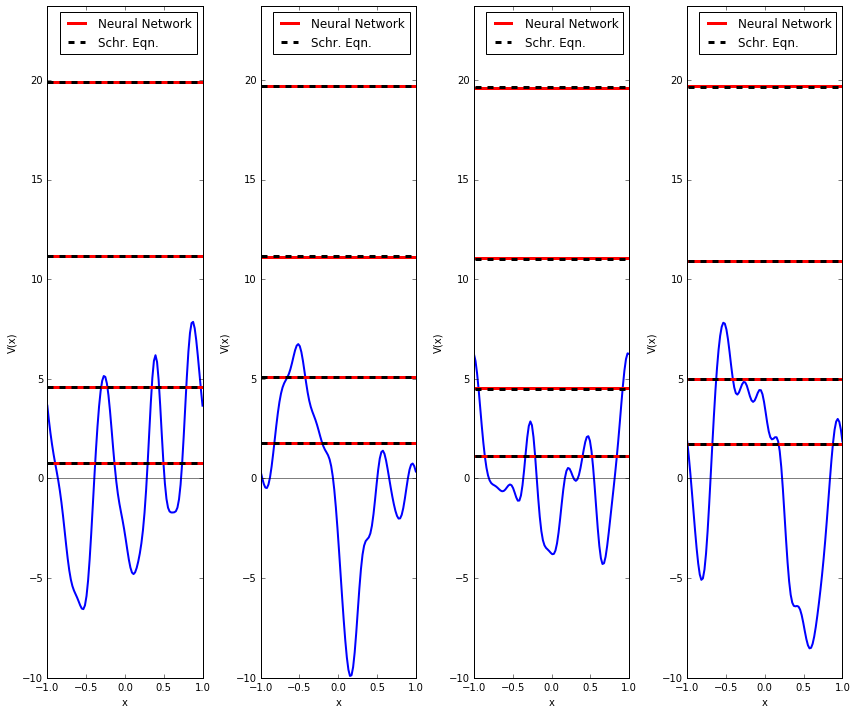

In [168]:
nrows = 1
ncols = 4
nplot = nrows * ncols
indplt = randint(0,X_test.shape[0], nplot)
numeigsplt = 4

def E0(n):
    return n**2 * np.pi**2 / 8.

plt.clf()
fig, axes = plt.subplots(nrows = nrows, ncols = ncols)
fig.set_size_inches(3*ncols,10*nrows)
subax = axes.flat

for i in range(0, len(indplt)):
        subax[i].plot(xs, Xgrid_test[indplt[i]], linewidth = 2, label='$V(x)$')
        subax[i].axhline(y=0,xmin=-1,xmax=1, linestyle='solid' ,color = 'k', lw=0.5)
        for j in range(0, numeigsplt):
            lastaxNN = subax[i].axhline(y=E0(j+1)+y_pred[indplt[i],j], xmin = -1, xmax = 1, 
                             ls = 'solid', color = 'r', lw = 3, label = 'Neural Network')
            lastaxSE = subax[i].axhline(y=E0(j+1)+y_test[indplt[i],j], xmin = -1, xmax = 1, 
                             ls = 'dashed', color = 'k', lw =3, label = 'Schr. Eqn.')

        subax[i].set_xlabel("x")
        subax[i].set_ylabel("V(x)")
        subax[i].set_ylim((-V20, 1.2*E0(numeigsplt)))
        subax[i].legend([lastaxNN, lastaxSE], ["Neural Network", "Schr. Eqn."])

plt.tight_layout();
plt.show();
plt.draw()
fig.savefig("../Plots/NNPred.png")